<a href="https://colab.research.google.com/github/gabrielliosc/music_effects_prediction/blob/main/music_effects_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Base utilizada para o modelo
# https://www.kaggle.com/datasets/catherinerasgaitis/mxmh-survey-results


import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#Pré-processamento dos dados

In [ ]:
#Carga dos dados
url_data = 'https://raw.githubusercontent.com/gabrielliosc/music_effects_prediction/refs/heads/main/data/mxmh_survey_results.csv?token=GHSAT0AAAAAACUZNJEBRRMYQFIQCZQXEW5IZXTM2EA'
dataset = pd.read_csv(url_data, on_bad_lines='warn',sep=";")

#Remove as colunas não necessárias
df = dataset.drop(['Timestamp', 'Permissions'], axis=1)

'''
  Tratamento dos dados
'''

#Substituição dos valores NaN
df['Music effects'].fillna('No Answer', inplace=True)
df['Primary streaming service'].fillna('No Answer', inplace=True)
df['While working'].fillna('No Answer', inplace=True)
df['Instrumentalist'].fillna('No Answer', inplace=True)
df['Composer'].fillna('No Answer', inplace=True)
df['Foreign languages'].fillna('No Answer', inplace=True)
df['Age'].fillna(0, inplace=True)
df['BPM'].fillna(0, inplace=True)

#Mudança do tipo da coluna
df['Age'] = df['Age'].astype(int)

#Mudança nas colunas categoricas
categorical_columns = ['Primary streaming service', 'Fav genre', 'While working', 'Instrumentalist', 'Composer', 'Exploratory', 'Foreign languages']
df_encoded = pd.get_dummies(df, columns=categorical_columns)

#Mapeia colunas de frequência para valores numéricos
frequency_columns = [col for col in df_encoded.columns if 'Frequency' in col]
mapping = {'Never': 0, 'Rarely': 1, 'Sometimes': 2, 'Very frequently': 3}
df_encoded[frequency_columns] = df_encoded[frequency_columns].applymap(lambda x: mapping[x])

#Mapeia a coluna target para valores númerico
label_mapping = {'No Answer': 0, 'No effect': 1, 'Improve': 2, 'Worsen': 3}
df_encoded['Music effects'] = df_encoded['Music effects'].map(label_mapping)

In [ ]:
df.head()

,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,BPM,...,Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects
0,15,Spotify,8.0,Yes,No,No,Rock,No,No,193.0,...,Rarely,Never,Never,Very frequently,Rarely,8.0,7.0,5.0,0.0,Improve
1,18,Spotify,2.0,No,Yes,Yes,Metal,Yes,Yes,149.0,...,Sometimes,Never,Rarely,Very frequently,Rarely,3.0,4.0,6.0,1.0,Improve
2,25,I do not use a streaming service.,0.5,No,Yes,No,Classical,No,No,140.0,...,Rarely,Rarely,Never,Very frequently,Sometimes,1.0,1.0,3.0,1.0,Improve
3,17,Apple Music,5.0,Yes,No,No,Metal,Yes,No,134.0,...,Sometimes,Sometimes,Sometimes,Very frequently,Rarely,10.0,8.0,6.0,7.0,No effect
4,28,YouTube Music,1.0,No,No,No,Rock,Yes,No,120.0,...,Rarely,Never,Never,Sometimes,Rarely,6.0,6.0,2.0,0.0,No effect


#Conjuto de dados

In [ ]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
X = df_encoded.drop(columns=['Music effects']).values
y = df_encoded['Music effects'].values #Target
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

#Gerando modelo

KNN-orig: 0.717 (0.051)
CART-orig: 0.617 (0.059)
NB-orig: 0.690 (0.158)
SVM-orig: 0.741 (0.008)
RF-orig: 0.731 (0.021)
KNN-padr: 0.709 (0.015)
CART-padr: 0.603 (0.062)
NB-padr: 0.165 (0.050)
SVM-padr: 0.741 (0.008)
RF-padr: 0.743 (0.020)
KNN-norm: 0.696 (0.048)
CART-norm: 0.615 (0.056)
NB-norm: 0.165 (0.050)
SVM-norm: 0.741 (0.008)
RF-norm: 0.741 (0.017)


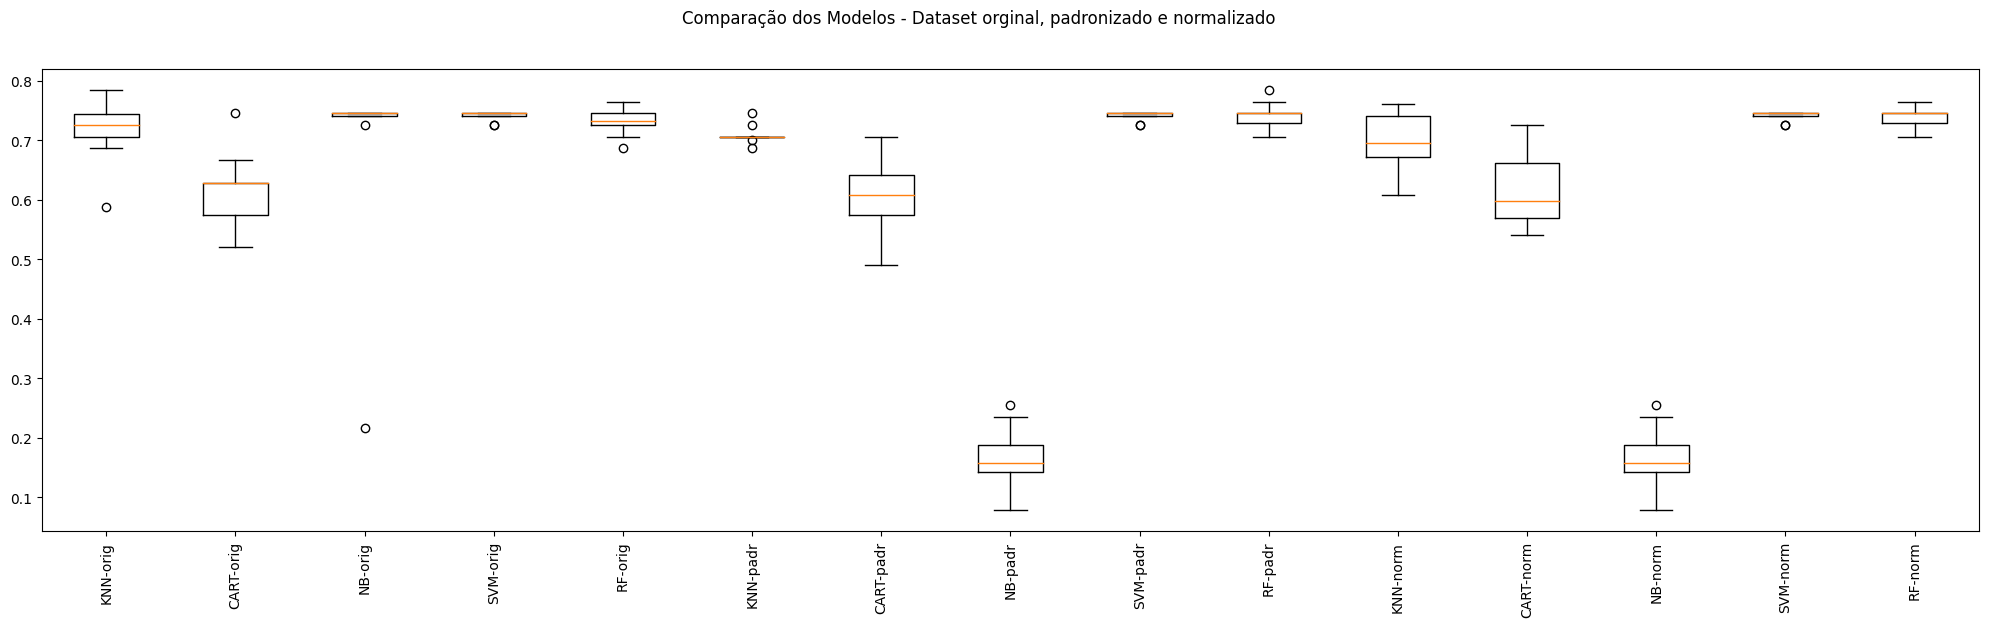

In [ ]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
random_forest = ('RF', RandomForestClassifier())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('RF-orig', Pipeline([random_forest])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()


#Treinamento do modelo

In [ ]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
model = SVC()
model.fit(X_train, y_train)

# Estimativa da acurácia no conjunto de teste
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))

# Preparação do modelo com TODO o dataset
model.fit(X, y)

0.7421875


SVC()

#Exportação dos dados e modelos

In [ ]:
#Exporta o modelo
with open('music_model.pkl', 'wb') as file:
    pickle.dump(model, file)
